## Transfer Learning Using CNN



With transfer learning, instead of starting the learning process from scratch, you start from patterns that have been learned when solving a new related problem. So we reuse initial and middle layers of our pre-trained model to re-train only final layers for our new task. A pre-trained model denotes a model that was trained on a large benchmark dataset to solve a problem similar to the one that we want to solve.


Fine tuning is a way of appliying or utilizing transfer learning. Specifically fine tuning is a process that takes a model that's already been trained for a given task and then tuning or tweaking that model to make it perform a second similiar task. If the two tasks are different and there will be some information that the model has learned that may not apply to our new task or there may be new information that the model needs to learn from the data regarding the new task that wasn't learned from the previous task. 



### Assignment


In this assignment, you will implement a transfer learning approach by using clinical images for a binary image classification task. The dataset consists of skin cancer images which are labeled as melanomas, nevus, and seborrheic keratoses. You will show the ability of your CNN to distinguish between malignant melanoma and benign skin lesions (nevus, seborrheic keratosis).  So you will create a binary classification model for Melanoma vs Nevus and Seborrheic keratosis. You will use pre-trained models which are two different CNN architectures (VGG16 and ResNet50) available in Pytorch [1]. Follow the steps below  to complete the assignment.

[1]: https://pytorch.org/vision/stable/models.html

**Steps**:

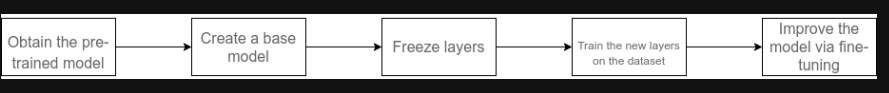


- Obtain the pre-trained model

The first step is to get the pre-trained model that is already given to you. You get pre-trained weights alongside each model. When you download a model, the weights are downloaded automatically. 

TorchVision offers pre-trained weights for every provided architecture, using the PyTorch *torch.hub* [2]. Instancing a pre-trained model will download its weights to a cache directory. This directory can be set using the TORCH_HOME environment variable. See *torch.hub.load_state_dict_from_url()*[3] for details.`

- Create a base model

The first step is to instantiate the base model using the architectures as VGG16 and ResNet50 separately. Download the pre-trained weights. If you don’t download the weights, you will have to use the architecture to train your model from scratch. Recall that the base model will usually have more units in the final output layer than you require. When creating the base model, you, therefore, have to remove the final output layer. Later on, you will add a final output layer that is compatible with your problem. 

- Freeze layers so they don’t change during training

Freezing the layers from the pre-trained model is important when using transfer learning or fine-tuning the model. This is because you don't want the weights in those layers to be significantly altered, as this may degrade the model's pre-existing knowledge. If the weights are changed too much, then the benefits of using a pre-trained model could be diminished, making it similar to training the model from scratch. However, it's worth noting that in some cases, fine-tuning might involve updating the weights of the pre-trained model, but with a smaller learning rate, so that the pre-existing knowledge is fine-tuned to the new task without being lost entirely. In such cases, the layers are not frozen but are still carefully updated to prevent losing the initial learning. 

- Add new trainable layers

The next step is to add new trainable layers that will turn old features into predictions on the new dataset. This is important because the pre-trained model is loaded without the final output layer. 

- Train the new layers on the dataset

Remember that the pre-trained model’s final output will most likely be different from the output that you want for your model.  You will add some new dense layers as you please, but most importantly, a final dense layer with units corresponding to the number of outputs expected by your model. 

- Improve the model via fine-tuning

Once you have done the previous step, you will have a model that can make predictions on your dataset. Now improve its performance through fine-tuning.

- Summarize history for accuracy

Plot a graph to demonstrate accuracy scores in train versus test sets. In your plot use x-axes for epoch and y a-axes for accuracy scores.


[2]: https://pytorch.org/docs/stable/hub.html#torch.hub.load_state_dict_from_url
[3]: https://pytorch.org/docs/stable/hub.html#module-torch.hub


## Submission

After training your models with the training and validation data, use the given test data for your predictions. In order to rank your results, you need to save your test results in a CSV file containing your test predictions like sample_predictions.csv and upload the test CSV file to the Kaggle competition. Furthermore, you are supposed to upload your coding in Jupyter notebook to the department's submission system.

Kaggle competition for VGG16 architecture: https://www.kaggle.com/t/7ee370dd307a47b8b182683a1e2f4a7f

Kaggle competition for ResNet50 architecture: https://www.kaggle.com/t/7f94629daea34740b9c21737e6b772a8

**Due Date**: 18.05.2023

**Note**: The late submission rules previously announced from the piazza apply.

### Your Work


In [ ]:
#Include your codes below by including as many cells as necessary to clearly demonstrate your work
#Please write your codes in separate sections for data pre-processing, VGG16 and ResNet50 architectures etc.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

from torchinfo import summary
from pytorchcv import train, plot_results, display_dataset, train_long, check_image_dir

c:\Users\usr\anaconda3\envs\deeplearning\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Preprocessing
Preprocessing step applied for personal training purposes and can be skipped just fine

Note that doing so will alter the original dataset

In [4]:
PREPROCESS = False # SWITCH IF PREPROCESSING SHOULD BE APPLIED

In [13]:
import cv2
from tqdm import tqdm

roots =["train", "valid", "test"]
if (PREPROCESS):
    for r in roots:
        for root, folder, files in os.walk(r):
            for file in tqdm(files):
                try:
                    path = os.path.join(root, file)
                    img = cv2.imread(path)
                    
                    h, w = img.shape[:2]
                    c = 3
                    dif = h if h >= w else w
                    inter = cv2.INTER_AREA
                    
                    x_pos = (dif - w)//2
                    y_pos = (dif - h)//2
                    mask = np.zeros((dif, dif, c), dtype=img.dtype)
                    mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]
                    
                    img = cv2.resize(mask, (224, 224), inter)
                    cv2.imwrite(path, img)
                except Exception:
                    print(path)


0it [00:00, ?it/s]
100%|██████████| 254/254 [00:41<00:00,  6.08it/s]
0it [00:00, ?it/s]
100%|██████████| 600/600 [03:04<00:00,  3.25it/s]


### VGG16

In [14]:
std_normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomAffine(degrees=180, translate=(0.1, 0.1), scale=(0.75, 1)), # Data augmentation added for overfitting
    transforms.ToTensor(),
    std_normalize])
val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    std_normalize])

train_dataset = torchvision.datasets.ImageFolder('train', transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder('valid', transform=val_transform)

In [5]:
vgg = torchvision.models.vgg16(pretrained=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vgg.classifier = nn.Sequential(
    torch.nn.Linear(512 * 7 * 7, 1024),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(1024, 32),
    torch.nn.ReLU(),
    torch.nn.Linear(32, 2)
)

vgg.to(device)

for x in vgg.features.parameters():
    x.requires_grad = False

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)

hist_vgg_tl = train(vgg, train_loader, val_loader, loss_fn=torch.nn.CrossEntropyLoss(), epochs=20, lr=1e-3)
torch.save(vgg, "vgg16.pth")

Epoch  0, Train acc=0.494, Val acc=0.200, Train loss=0.012, Val loss=0.014
Epoch  1, Train acc=0.507, Val acc=0.227, Train loss=0.011, Val loss=0.014
Epoch  2, Train acc=0.555, Val acc=0.420, Train loss=0.011, Val loss=0.014
Epoch  3, Train acc=0.625, Val acc=0.707, Train loss=0.010, Val loss=0.012
Epoch  4, Train acc=0.656, Val acc=0.653, Train loss=0.010, Val loss=0.012
Epoch  5, Train acc=0.666, Val acc=0.693, Train loss=0.010, Val loss=0.012
Epoch  6, Train acc=0.710, Val acc=0.720, Train loss=0.009, Val loss=0.012
Epoch  7, Train acc=0.693, Val acc=0.760, Train loss=0.009, Val loss=0.012
Epoch  8, Train acc=0.696, Val acc=0.720, Train loss=0.009, Val loss=0.012
Epoch  9, Train acc=0.703, Val acc=0.600, Train loss=0.009, Val loss=0.012
Epoch 10, Train acc=0.700, Val acc=0.707, Train loss=0.009, Val loss=0.011
Epoch 11, Train acc=0.716, Val acc=0.753, Train loss=0.009, Val loss=0.012
Epoch 12, Train acc=0.704, Val acc=0.753, Train loss=0.009, Val loss=0.012
Epoch 13, Train acc=0.728

In [6]:
for x in vgg.features.parameters():
    x.requires_grad = True

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
    
hist_vgg_ft = train(vgg, train_loader, val_loader, loss_fn=torch.nn.CrossEntropyLoss(), epochs=5, lr=1e-5)
torch.save(vgg, "vgg16_finetuned.pth")

Epoch  0, Train acc=0.732, Val acc=0.720, Train loss=0.016, Val loss=0.018
Epoch  1, Train acc=0.757, Val acc=0.773, Train loss=0.015, Val loss=0.017
Epoch  2, Train acc=0.790, Val acc=0.780, Train loss=0.014, Val loss=0.016
Epoch  3, Train acc=0.806, Val acc=0.780, Train loss=0.013, Val loss=0.017
Epoch  4, Train acc=0.795, Val acc=0.787, Train loss=0.013, Val loss=0.017


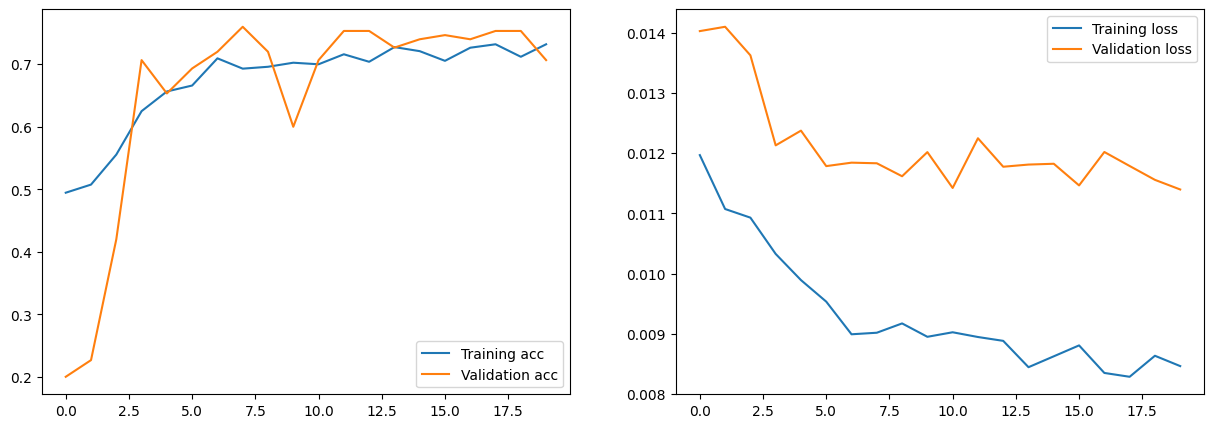

In [24]:
plot_results(hist_vgg_tl)

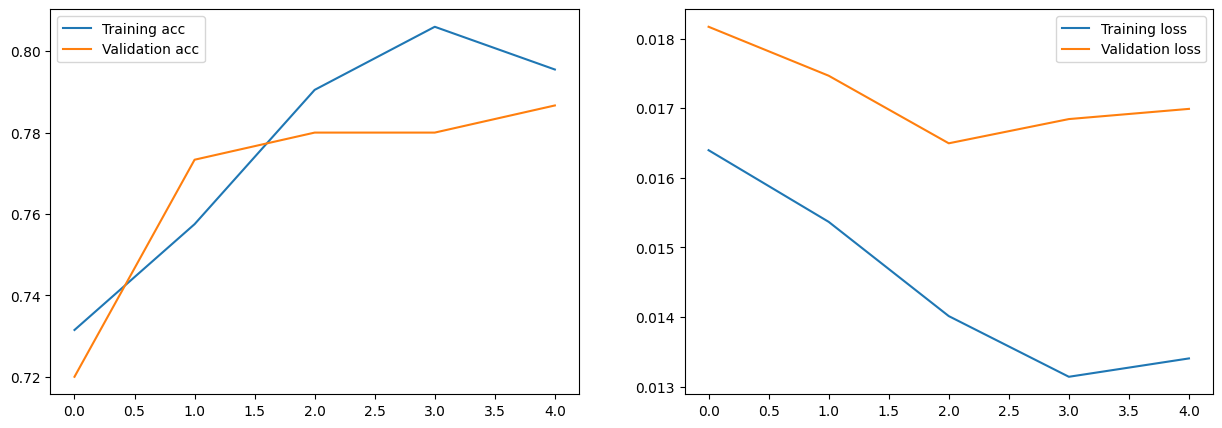

In [25]:
plot_results(hist_vgg_ft)

#### ResNet50

In [4]:
resnet = torchvision.models.resnet50(pretrained=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

for param in resnet.parameters():
    param.requires_grad = False

resnet.fc = nn.Sequential(
    torch.nn.Linear(2048, 64),
    torch.nn.ReLU(),
    torch.nn.Dropout(),
    torch.nn.Linear(64, 8),
    torch.nn.ReLU(),
    torch.nn.Linear(8, 2)
)

resnet.to(device)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)

hist_resnet_tl = train(resnet, train_loader, val_loader,
                    loss_fn=torch.nn.CrossEntropyLoss(), epochs=20, lr=1e-3)
torch.save(resnet, "resnet50.pth")


Epoch  0, Train acc=0.488, Val acc=0.787, Train loss=0.011, Val loss=0.014
Epoch  1, Train acc=0.544, Val acc=0.800, Train loss=0.011, Val loss=0.014
Epoch  2, Train acc=0.552, Val acc=0.687, Train loss=0.011, Val loss=0.013
Epoch  3, Train acc=0.594, Val acc=0.687, Train loss=0.011, Val loss=0.013
Epoch  4, Train acc=0.625, Val acc=0.547, Train loss=0.010, Val loss=0.013
Epoch  5, Train acc=0.639, Val acc=0.480, Train loss=0.010, Val loss=0.013
Epoch  6, Train acc=0.663, Val acc=0.653, Train loss=0.010, Val loss=0.012
Epoch  7, Train acc=0.658, Val acc=0.633, Train loss=0.010, Val loss=0.012
Epoch  8, Train acc=0.684, Val acc=0.700, Train loss=0.010, Val loss=0.012
Epoch  9, Train acc=0.677, Val acc=0.720, Train loss=0.010, Val loss=0.012
Epoch 10, Train acc=0.677, Val acc=0.713, Train loss=0.010, Val loss=0.012
Epoch 11, Train acc=0.658, Val acc=0.573, Train loss=0.010, Val loss=0.013
Epoch 12, Train acc=0.688, Val acc=0.667, Train loss=0.009, Val loss=0.012
Epoch 13, Train acc=0.695

In [5]:
for param in resnet.parameters():
    param.requires_grad = True

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=32, sampler=ImbalancedDatasetSampler(train_dataset))
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)

hist_resnet_ft = train(resnet, train_loader, val_loader,
                    loss_fn=torch.nn.CrossEntropyLoss(), epochs=5, lr=1e-5)
torch.save(resnet, "resnet50_finetuned.pth")


Epoch  0, Train acc=0.697, Val acc=0.687, Train loss=0.018, Val loss=0.018
Epoch  1, Train acc=0.731, Val acc=0.780, Train loss=0.017, Val loss=0.016
Epoch  2, Train acc=0.745, Val acc=0.787, Train loss=0.016, Val loss=0.015
Epoch  3, Train acc=0.789, Val acc=0.780, Train loss=0.015, Val loss=0.015
Epoch  4, Train acc=0.784, Val acc=0.807, Train loss=0.015, Val loss=0.014


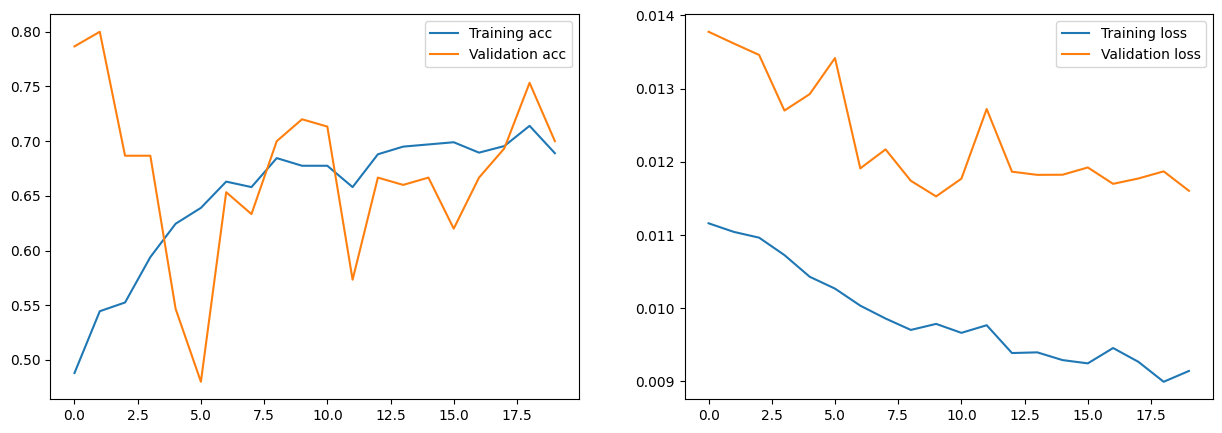

In [29]:
plot_results(hist_resnet_tl)

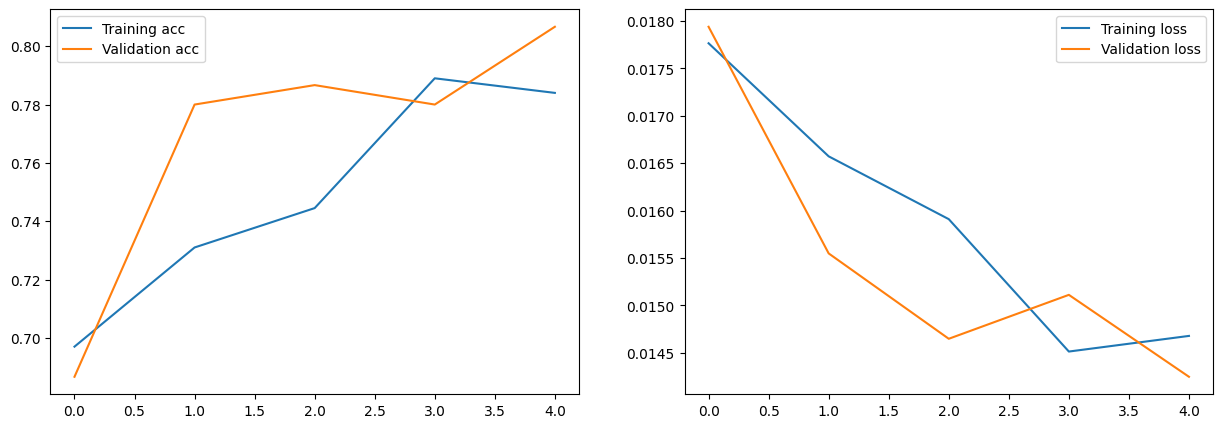

In [30]:
plot_results(hist_resnet_ft)

#### Make Predictions

In [ ]:
import os
from PIL import Image
import pandas as pd

In [ ]:
vgg_res = pd.DataFrame(columns=['Id', 'label'])
for root, folder, files in os.walk('test'):
    for i, file in enumerate(files):
        path = os.path.join(root, file)
        img = Image.open(path)
        img = val_transform(img)
        img = img.unsqueeze(0)
        img = img.cuda()

        with torch.no_grad():
            output = vgg(img)

        _, predicted_class = torch.max(output, 1)

        vgg_res.loc[i] = file, predicted_class.item()

vgg_res.to_csv('vgg16_res.csv', index=False)

In [ ]:
resnet_res = pd.DataFrame(columns=['Id', 'label'])
for root, folder, files in os.walk('test'):
    for i, file in enumerate(files):
        path = os.path.join(root, file)
        img = Image.open(path)
        img = val_transform(img)
        img = img.unsqueeze(0)
        img = img.cuda()

        with torch.no_grad():
            output = resnet(img)

        _, predicted_class = torch.max(output, 1)

        resnet_res.loc[i] = file, predicted_class.item()

resnet_res.to_csv('resnet50_res.csv', index=False)